<h1 align="center" style="color: #46E884;">AMAZON </h1>
<p ">Amazon es un sitio web de compras en línea que ahora atiende a millones de personas en todo el mundo. Se proporcionan más de 34.000 reseñas de consumidores sobre productos de la marca Amazon como Kindle, Fire TV Stick y más. El conjunto de datos tiene atributos como marca, categorías, categorías principales, reseñas.título, reseñas.texto y sentimiento. El sentimiento es una variable categórica con tres niveles: "Positivo", "Negativo" y "Neutral". Para datos no vistos determinados, es necesario predecir el sentimiento. Debe predecir el sentimiento o la satisfacción de una compra en función de múltiples características y revisar el texto.
</p>
<p align="center">
  <img src="https://cdn.icon-icons.com/icons2/1178/PNG/512/amazon-a-inverted_82088.png" alt="Amazon Logo">
</p>


<h1 style="color: #46E884;">Configuración del proyecto</h1>
<h3>Comenzamos importando las librerías </h3>

In [37]:
# Librerías básicas
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from wordcloud import WordCloud,STOPWORDS
nltk.download('stopwords')


# Librerías para preprocesamiento de texto
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords


# Librerías para modelado
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Embedding, SpatialDropout1D, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import LabelEncoder
from transformers import AdamW
import torch
from keras import models
from keras import layers
from keras import regularizers


# Librerías para evaluación
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JOHANPC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Dataset original

In [38]:
df = pd.read_csv('./data/train_data.csv')
df = df.reindex(np.random.permutation(df.index))  
df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
2573,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-02-06T00:00:00.000Z,"the tablet was on sale for a good price, and t...",good price for the tablet,Positive
1939,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-12-09T00:00:00.000Z,"Love it , it‚Äôs my second Alexa it‚Äôs concet...",Alexa show,Positive
1337,"Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...",Amazon,"Computers,Fire Tablets,Electronics Features,Co...",Electronics,2017-04-16T00:00:00.000Z,I recommend it for kids .great for find games ...,Great Tablet.,Positive
3078,"Kindle E-reader - White, 6 Glare-Free Touchscr...",Amazon,"Office,eBook Readers,Electronics Features,Walm...","Office Supplies,Electronics",2016-10-15T00:00:00.000Z,I prefer the Kindle to a book. I like the chan...,"I've had one before, so I knew I'd be happy",Positive
1338,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",Amazon,"Fire Tablets,Tablets,All Tablets,Amazon Tablets",Electronics,2017-03-20T00:00:00.000Z,This 8 inch Fire is definitely better than the...,Decent Tablet for Teen Basic Games,Positive


### Hiperparámetros

In [39]:
NB_WORDS = 10000  # Indica la cantidad de palabras que se van a utilizar
VAL_SIZE = 1000  # Tamaño del conjunto de validación
NB_START_EPOCHS = 20  # Número de épocas
BATCH_SIZE = 512  # Tamaño de los lotes
MAX_LEN = 100  # Número máximo de palabras en una secuencia
EMBEDDING_DIM = 128  # Dimensión del embedding vector

Leemos el csv con los datos de las reseñas y realizamos una mezcla aleatoria. Es una buena práctica mezclar los datos antes de dividirlos entre train, validation y test data. De esta manera, las clases de sentimiento se distribuyen equitativamente entre el train, validation y test y los conjuntos de prueba.

Solo mantendremos la columna *reseñas* como entrada y la columna *sentiment* como destino.

In [40]:
#Renombrar las columnas
df = df.rename(columns={'reviews.text': 'reviews',})

#Solo se hará uso de 2 columnas
df = df[['reviews', 'sentiment']]

df.head()

,reviews,sentiment
2573,"the tablet was on sale for a good price, and t...",Positive
1939,"Love it , it‚Äôs my second Alexa it‚Äôs concet...",Positive
1337,I recommend it for kids .great for find games ...,Positive
3078,I prefer the Kindle to a book. I like the chan...,Positive
1338,This 8 inch Fire is definitely better than the...,Positive


### Filas totales en el dataset

In [41]:
df.count()

reviews      4000
sentiment    4000
dtype: int64

### Columnas usadas

In [42]:
df.columns

Index(['reviews', 'sentiment'], dtype='object')

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 2573 to 361
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   reviews    4000 non-null   object
 1   sentiment  4000 non-null   object
dtypes: object(2)
memory usage: 93.8+ KB


In [44]:
df.duplicated().sum()

402

### Valores repetidos

In [45]:
df['reviews'].duplicated().sum()


402

In [46]:
df['sentiment'].duplicated().sum()


3997

In [47]:
import pandas as pd

# Suponiendo que tienes un DataFrame llamado df con una columna llamada 'reviews'
# Carga tus datos en un DataFrame (reemplaza 'tu_archivo.csv' con el nombre de tu archivo CSV o 'tu_tabla' con el nombre de tu tabla en una base de datos)
# df = pd.read_csv('tu_archivo.csv')

# Encuentra y muestra todos los valores duplicados en la columna 'reviews'
duplicados = df[df.duplicated(subset=['reviews'], keep=False)]
print("\nTodos los valores duplicados:")
print(duplicados)

# Itera sobre los valores duplicados y muestra cada review repetida
for index, row in duplicados.iterrows():
    review = row['reviews']
    cantidad_repeticiones = df[df['reviews'] == review].shape[0]
    print(f"Review: {review} - Repeticiones: {cantidad_repeticiones}")





Todos los valores duplicados:
                                                reviews sentiment
3078  I prefer the Kindle to a book. I like the chan...  Positive
3731  I hope to find all my books in the electronic ...  Positive
3869  I love all of my Amazon echo devices. Right no...  Positive
3894  Gave it to my grandkids(ages 3, 4 & 9) for Chr...  Positive
354   I love that you can read books as well as play...  Positive
...                                                 ...       ...
2617  Blue is beautiful & allows grand-daughter to b...  Positive
1692  My 3 1/2 year old grandson son LOVES this "big...  Positive
1054  It's a good starter tablet, to bad it runs on ...  Positive
552   Got this tablet to replace the one that had th...  Positive
748   The Amazon Show is a great addition to the Sma...  Positive

[764 rows x 2 columns]
Review: I prefer the Kindle to a book. I like the change of letter size, storing many, many books, and the ease of carrying it. I love to read when I tra

Review: Wife really likes it. Works great& likes the front & back camera. - Repeticiones: 2
Review: The echo show works very well with Bluetooth and WiFi. Great sound and screen. Recommend to anyone - Repeticiones: 2
Review: I have to say it was a little confusing and frustrating when i was not getting the verification code from amazon , i waited for 20 minutes then i requested another code, nothing... then a nother one... and still nothing , i started to set up the device at 8.30 am and by 11.20 am i was fed up with it.. i had to step away.... after about 5 hours we went shopping and at the mall i recieved about 4 codes from amazon .... - Repeticiones: 2
Review: My son just love playing games on this tablet. Its easy and fun! - Repeticiones: 2
Review: Bought this with the intention of reading more, it serves it's purpose! I will be purchasing another one soon for my nephew, for his books and learning games. - Repeticiones: 3
Review: My mom loves the kindle fire hd 8. She had the first

In [48]:
df.isnull().sum()

reviews      0
sentiment    0
dtype: int64

In [49]:
df.dtypes

reviews      object
sentiment    object
dtype: object

In [50]:
df.describe()

,reviews,sentiment
count,4000,4000
unique,3598,3
top,Got this for my Daughter-in-Law and she loves ...,Positive
freq,4,3749


## EDA básico del conjunto de datos de entrenamiento 

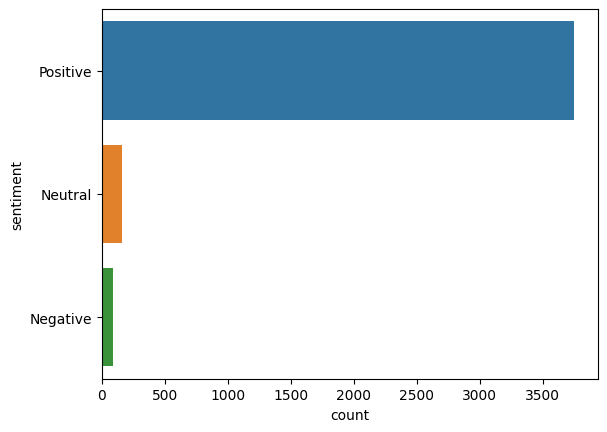

In [51]:
sns.countplot(y=df.sentiment);

<AxesSubplot:xlabel='sentiment', ylabel='count'>

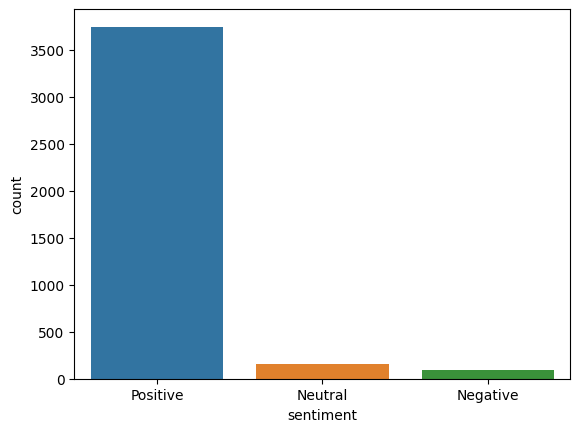

In [52]:
sns.countplot(x='sentiment', data=df)


In [53]:
df.sentiment.value_counts()

Positive    3749
Neutral      158
Negative      93
Name: sentiment, dtype: int64

<AxesSubplot:ylabel='sentiment'>

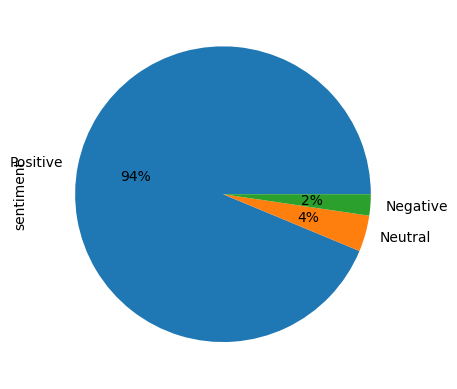

In [54]:
df['sentiment'].value_counts().plot(kind='pie', autopct= '%1.0f%%')

<h1 style="color: #46E884;">Nube de palabras</h1>


Positive words


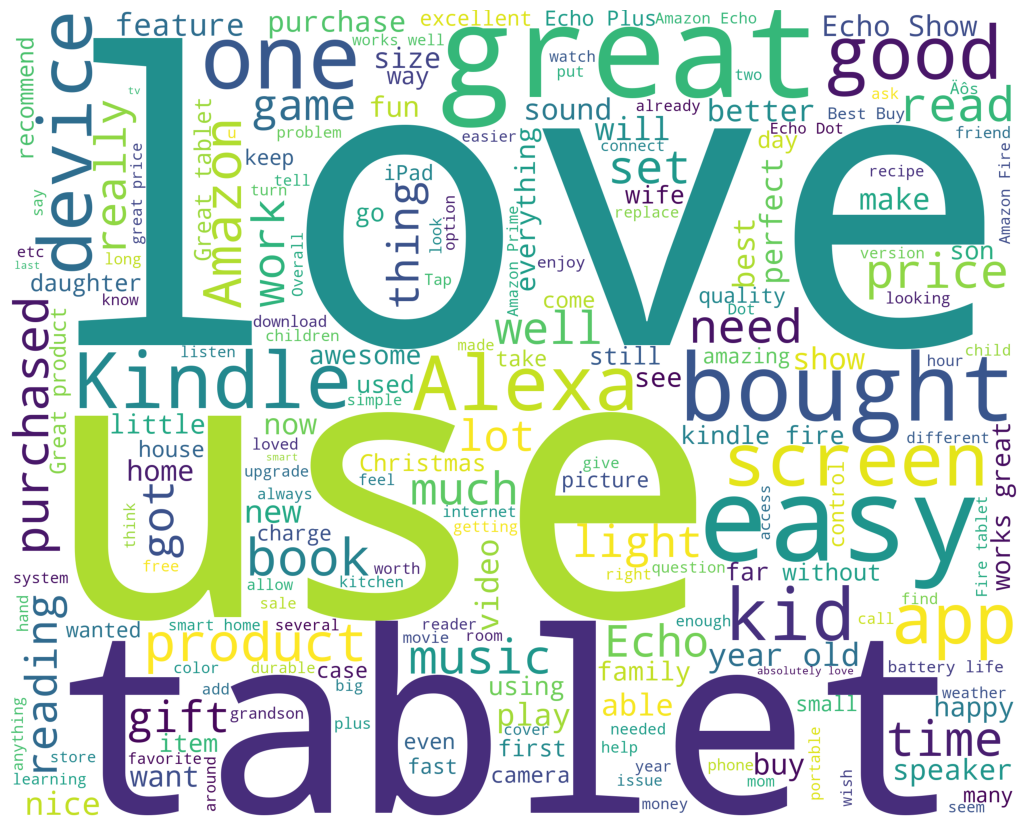

Negative words


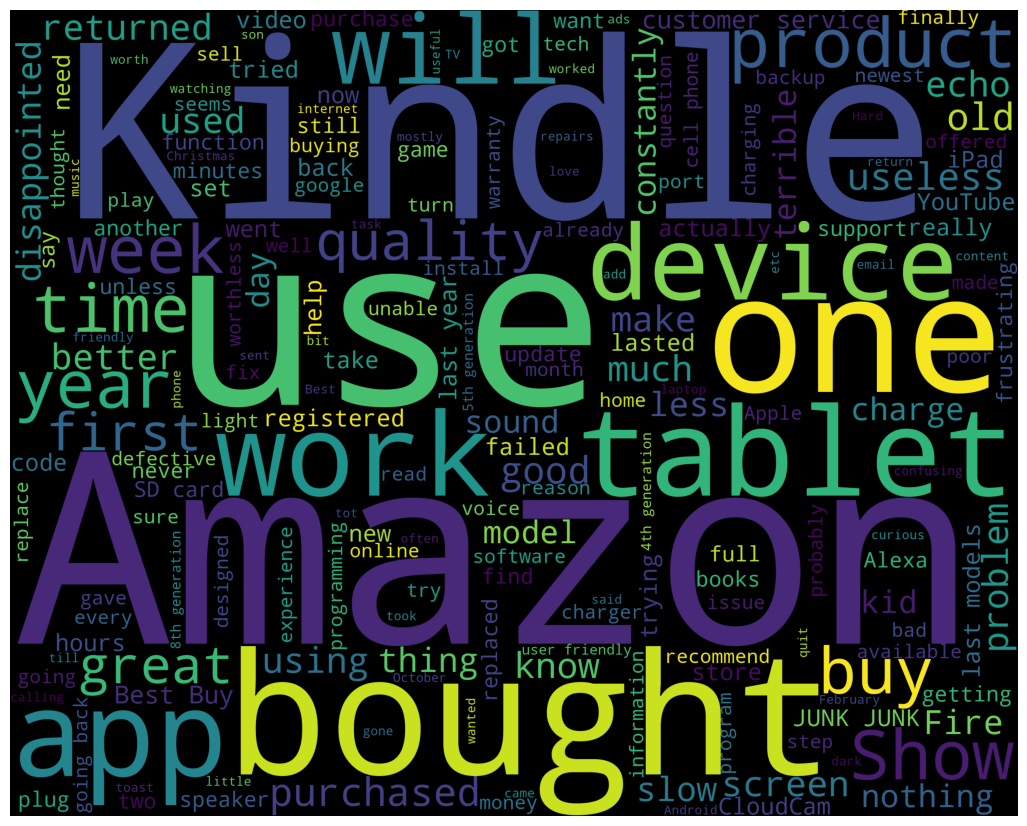

In [55]:
#obtener reviews positivas y negativas
train_pos = df[ df['sentiment'] == 'Positive']
train_pos = train_pos['reviews']
train_neg = df[ df['sentiment'] == 'Negative']
train_neg = train_neg['reviews']

#funcion para generar nube de palabras
def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    #cleaning de las reviews
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    #caracteristicas de la nube de palabras
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
#imprimir nube de palabras
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

<h1  align="center" style="color: #46E884;">Data preparation</h1>


### Data cleaning
Lo primero que haremos será eliminar las palabras vacías (stopwords). Estas palabras no tienen ningún valor para predecir el sentimiento. Además, como queremos crear un modelo que también pueda usarse para otros datasets, eliminamos las menciones.


In [56]:
#funcion para eliminar stopwords y menciones
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
    
def remove_mentions(input_text):
        return re.sub(r'@\w+', '', input_text)
       
df.reviews = df.reviews.apply(remove_stopwords).apply(remove_mentions)
df.head()

,reviews,sentiment
2573,"tablet sale good price, enough stock CHRISTMAS...",Positive
1939,Love it‚Äôs second Alexa it‚Äôs conceted every...,Positive
1337,recommend kids .great find games easily.,Positive
3078,"prefer Kindle book. like change letter size, s...",Positive
1338,This inch Fire definitely better cheaper inch....,Positive


### Train, y Test split
Dividimos los datos en dos conjuntos, ya que estamos definiendo al comienzo del notebook los hiperparametros de forma explícita.


In [57]:
X_train, X_test, y_train, y_test = train_test_split(df.reviews, df.sentiment, test_size=0.1, random_state=42)

print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 3600
# Test data samples: 400


### Convertir palabras en números
Para usar el texto como entrada para un modelo, primero necesitamos convertir las palabras de las reseñas en tokes, lo que simplemente significa convertir las palabras en números enteros que hacen referencia a un índice en un diccionario. Aquí sólo mantendremos las palabras más frecuentes en el conjunto de trenes.

Limpiamos el texto aplicando *filtros* y poniendo las palabras en *minúsculas*. Las palabras están separadas por espacios.

In [58]:
# Tokenizar 
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 3600 documents
10000 words in dictionary
Top 5 most common words are: [('it', 1242), ('great', 1172), ('tablet', 945), ('the', 777), ('use', 763)]


Después de haber creado el diccionario podemos convertir el texto a una lista de índices enteros. Esto se hace con el método *text_to_sequences* del Tokenizer.

In [59]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

"Purchased Black FridayPros Great Price (even sale)Very powerful fast quad core processors Amazing soundWell builtCons -Amazon ads, Amazon need subsidize tablet remove adds pay $15.Inability access apps except ones Amazon. There way able accomplish add Google Play storeNet great tablet money" is converted into [311, 31, 119, 278, 152, 245, 272, 14, 89, 159, 782, 36, 2145, 783, 14, 59, 7, 329, 152, 72, 115, 160, 312, 17, 259, 1229, 105, 48, 1054, 22, 89, 31, 14, 134, 35, 152]


In [60]:
X_train_seq = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print('Shape of X_train_seq_trunc:', X_train_seq.shape)

Shape of X_train_seq_trunc: (3600, 100)


Estos números enteros ahora deberían convertirse en características codificadas en caliente (one-hot-encoding).

In [61]:
#funcion one hot encoding
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))


"[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0  311   31  119  278  152  245
  272   14   89  159  782   36 2145  783   14   59    7  329  152   72
  115  160  312   17  259 1229  105   48 1054   22   89   31   14  134
   35  152]" is converted into [1. 0. 0. ... 0. 0. 0.]
For this example we have 31.0 features with a value of 1.


In [62]:
np.set_printoptions(threshold=np.inf)

# Imprimir la matriz X_train_oh[5] sin puntos suspensivos
print(X_train_oh[5])

# Restaurar la configuración original de impresión de numpy
np.set_printoptions(threshold=1000)  # Opcional: restaurar el valor original

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.

### Converting the target classes to numbers
We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the *to_categorical* method in keras

In [63]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"Positive" is converted into 2
"2" is converted into [0. 0. 1.]


### Splitting of a validation set
Now that our data is ready, we split of a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model. 

In [64]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

#X_valid = pad_sequences(X_valid, maxlen=MAX_LEN)
#X_train_rest = pad_sequences(X_train_rest, maxlen=MAX_LEN)


print('Shape of validation set:',X_valid.shape)

Shape of validation set: (360, 10000)


<h1 style="color: #46E884;">Deep learning</h1>


### Baseline model
We start with a model with 2 densely connected layers of 64 hidden elements. The *input_shape* for the first layer is equal to the number of words we allowed in the dictionary and for which we created one-hot-encoded features.

As we need to predict 3 different sentiment classes, the last layer has 3 hidden elements. The *softmax* activation function makes sure the three probabilities sum up to 1.

In the first layer we need to estimate 640064 weights. This is determined by (nb inputs * nb hidden elements) + nb bias terms, or (10000 x 64) + 64 = 640064<br>
In the second layer we estimate (64 x 64) + 64 = 4160 weights<br>
In the last layer we estimate (64 x 3) + 3 = 195 weights<br>

In [65]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                640064    
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


## funciones de entrenamiento  y evaluación

Because this project is a multi-class, single-label prediction, we use *categorical_crossentropy* as the loss function and *softmax* as the final activation function. We fit the model on the remaining train data and validate on the validation set. We run for a predetermined number of epochs and will see when the model starts to overfit.

In [66]:
#Función de entrenamient
def deep_model(model):
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy']
                  , 
                  )
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [67]:
#History of the base model
base_history = deep_model(base_model)

To evaluate the model performance, we will look at the training and validation loss and accuracy.

In [68]:
#función para evaluar metricas
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

We can see here that the validation loss starts to increase as from epoch 4. The training loss continues to lower, which is normal as the model is trained to fit the train data as good as possible.

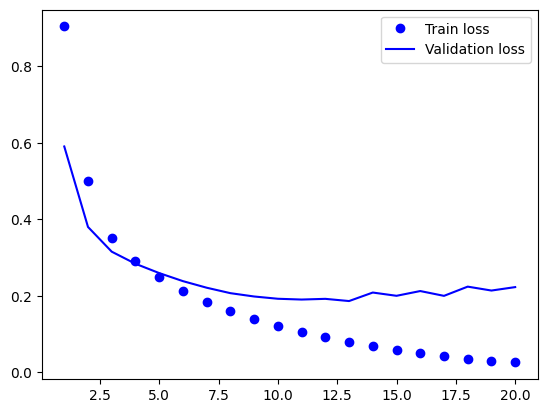

In [69]:
eval_metric(base_history, 'loss')

Just as with the validation loss, the validation accuracy peaks at an early epoch. After that, it goes down slightly. So to conclude, we can say that the model starts overfitting as from epoch 4. 

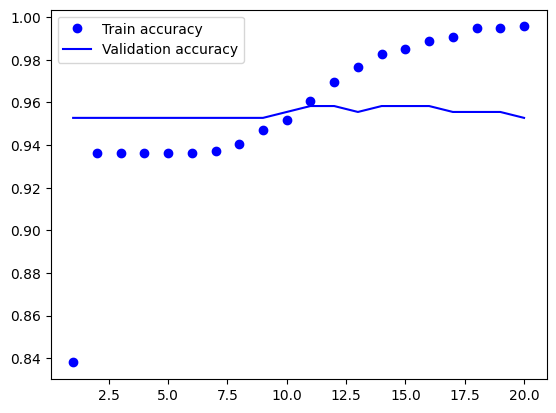

In [70]:
eval_metric(base_history, 'accuracy')


### Handling overfitting
Now, we can try to do something about the overfitting. There are different options to do that.
* Option 1: reduce the network's size by removing layers or reducing the number of hidden elements in the layers
* Option 2: add regularization, which comes down to adding a cost to the loss function for large weights
* Option 3: adding dropout layers, which will randomly remove certain features by setting them to zero

#### Reducing the network's size
We reduce the network's size by removing one layer and lowering the number of hidden elements in the remaining layer to 32.

In [71]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                320032    
                                                                 
 dense_10 (Dense)            (None, 3)                 99        
                                                                 
Total params: 320,131
Trainable params: 320,131
Non-trainable params: 0
_________________________________________________________________


In [72]:
reduced_history = deep_model(reduced_model)

In [73]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

We can see that it takes more epochs before the reduced model starts overfitting (around epoch 10). Moreover, the loss increases much slower after that epoch compared to the baseline model.

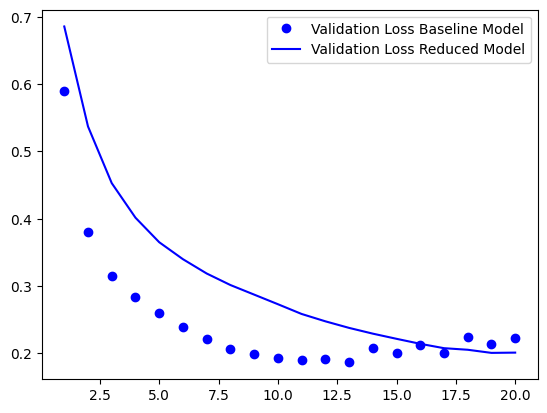

In [74]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

#### Adding regularization
To address overfitting, we can also add regularization to the model. Let's try with L2 regularization.

In [75]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 64)                640064    
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [76]:
reg_history = deep_model(reg_model)

For the regularized model we notice that it starts overfitting earlier than the baseline model. However, the loss increases much slower afterwards.

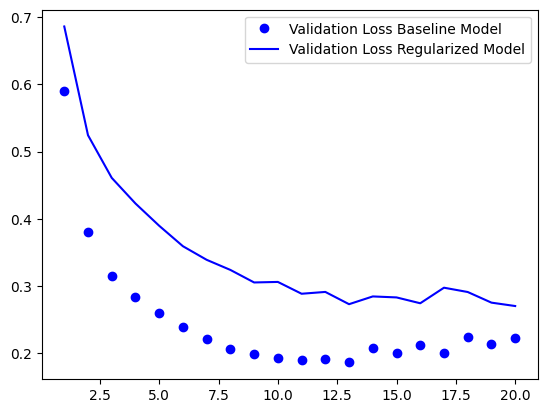

In [77]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

#### Adding dropout layers
The last option we'll try is to add dropout layers.

In [78]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [79]:
drop_history = deep_model(drop_model)

The model with dropout layers starts overfitting a bit later than the baseline model. The loss also increases slower than the baseline model.

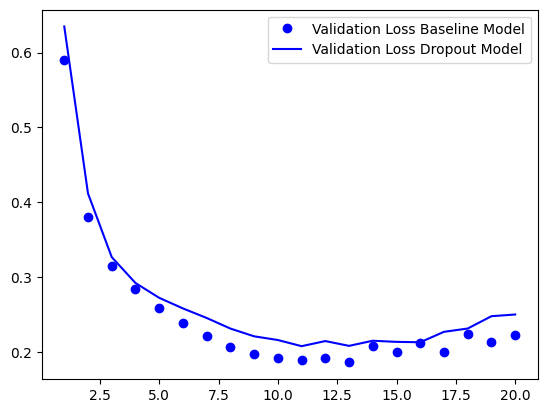

In [80]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

### Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalization. But let's check that on the test set.

In [81]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [82]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

13/13 [==============================] - 0s 3ms/step - loss: 0.2822 - accuracy: 0.9425
/n
Test accuracy of baseline model: 94.25%


In [83]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

13/13 [==============================] - 0s 2ms/step - loss: 0.2116 - accuracy: 0.9425
/n
Test accuracy of reduced model: 94.25%


In [84]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

13/13 [==============================] - 0s 6ms/step - loss: 0.2968 - accuracy: 0.9425
/n
Test accuracy of regularized model: 94.25%


In [85]:
drop_results = test_model(drop_model, 6)
print('/n')
print('Test accuracy of dropout model: {0:.2f}%'.format(drop_results[1]*100))

13/13 [==============================] - 0s 3ms/step - loss: 0.2777 - accuracy: 0.9450
/n
Test accuracy of dropout model: 94.50%


In [90]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(2000, embed_dim,input_length = 100))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 128)         0         
 ropout1D)                                                       
                                                                 
 lstm_2 (LSTM)               (None, 196)               254800    
                                                                 
 dense_19 (Dense)            (None, 3)                 591       
                                                                 
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


# CONVOLUTIONAL NEURAL NETWORKS CNN

In [143]:
# Definir constantes
NB_WORDS = 10000  # Número máximo de palabras a considerar
EMBEDDING_DIM = 100  # Dimensión de los vectores de embedding
MAX_LEN = 100  # Longitud máxima de las secuencias de palabras
VAL_SIZE = 0.2  # Proporción del conjunto de datos para usar como conjunto de validación
NB_START_EPOCHS = 8  # Número de épocas para entrenar
BATCH_SIZE = 32  # Tamaño del lote durante el entrenamiento

# Cargar el conjunto de datos
df = pd.read_csv('./data/train_data.csv')
df = df.reindex(np.random.permutation(df.index))

# Renombrar la columna de texto de las revisiones
df = df.rename(columns={'reviews.text': 'reviews'})

# Seleccionar columnas relevantes
df = df[['reviews', 'sentiment']]

df = df.dropna(subset=['sentiment'])
df['sentiment'] = le.fit_transform(df['sentiment'])

# Dividir el conjunto de datos en conjuntos de entrenamiento y validación
train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviews'], df['sentiment'], test_size=VAL_SIZE, random_state=42)

# Tokenizar texto y convertirlo a secuencias numéricas
tokenizer = Tokenizer(num_words=NB_WORDS)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Padding para que todas las secuencias tengan la misma longitud
train_data = pad_sequences(train_sequences, maxlen=MAX_LEN)
val_data = pad_sequences(val_sequences, maxlen=MAX_LEN)

# One Hot Encoding para las etiquetas
train_labels_oh = to_categorical(train_labels, num_classes=3)
val_labels_oh = to_categorical(val_labels, num_classes=3)

# Construir el modelo CNN
model = Sequential([
    Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Conv1D(128, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 clases de sentimiento
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_data, train_labels_oh, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels_oh))

# Predecir clases para los datos de validación
val_predictions = model.predict(val_data)

# Obtener las clases predichas
predicted_classes = np.argmax(val_predictions, axis=1)

Epoch 1/8
100/100 [==============================] - 5s 44ms/step - loss: 0.3595 - accuracy: 0.9266 - val_loss: 0.2327 - val_accuracy: 0.9463
Epoch 2/8
100/100 [==============================] - 5s 48ms/step - loss: 0.2405 - accuracy: 0.9350 - val_loss: 0.2033 - val_accuracy: 0.9463
Epoch 3/8
100/100 [==============================] - 4s 42ms/step - loss: 0.1653 - accuracy: 0.9406 - val_loss: 0.1893 - val_accuracy: 0.9475
Epoch 4/8
100/100 [==============================] - 4s 41ms/step - loss: 0.0964 - accuracy: 0.9591 - val_loss: 0.2224 - val_accuracy: 0.9463
Epoch 5/8
100/100 [==============================] - 4s 39ms/step - loss: 0.0513 - accuracy: 0.9800 - val_loss: 0.2809 - val_accuracy: 0.9450
Epoch 6/8
100/100 [==============================] - 5s 46ms/step - loss: 0.0320 - accuracy: 0.9906 - val_loss: 0.3188 - val_accuracy: 0.9488
Epoch 7/8
100/100 [==============================] - 4s 38ms/step - loss: 0.0201 - accuracy: 0.9959 - val_loss: 0.3669 - val_accuracy: 0.9488
Epoch 

In [144]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calcular métricas
accuracy = accuracy_score(val_labels, predicted_classes)
precision = precision_score(val_labels, predicted_classes, average='weighted')
recall = recall_score(val_labels, predicted_classes, average='weighted')
f1 = f1_score(val_labels, predicted_classes, average='weighted')
conf_matrix = confusion_matrix(val_labels, predicted_classes)

# Mostrar las métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.94125
Precision: 0.9429706634086057
Recall: 0.94125
F1 Score: 0.933555351440598
Confusion Matrix:
 [[  3   2  16]
 [  0   7  15]
 [  0  14 743]]


# RECURRENT NEURAL NETWORKS (RNN)

In [145]:
# Construir el modelo RNN
model_rnn = Sequential([
    Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 clases de sentimiento
])

# Compilar el modelo RNN
model_rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo RNN
history_rnn = model_rnn.fit(train_data, train_labels_oh, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels_oh))

# Predecir clases para los datos de validación utilizando el modelo RNN
val_predictions_rnn = model_rnn.predict(val_data)

# Obtener las clases predichas
predicted_classes_rnn = np.argmax(val_predictions_rnn, axis=1)

Epoch 1/8
100/100 [==============================] - 20s 166ms/step - loss: 3234.6204 - accuracy: 0.9244 - val_loss: 132.7950 - val_accuracy: 0.9463
Epoch 2/8
100/100 [==============================] - 16s 155ms/step - loss: 0.3694 - accuracy: 0.9350 - val_loss: 0.2251 - val_accuracy: 0.9463
Epoch 3/8
100/100 [==============================] - 19s 193ms/step - loss: 0.2414 - accuracy: 0.9350 - val_loss: 0.2199 - val_accuracy: 0.9463
Epoch 4/8
100/100 [==============================] - 18s 183ms/step - loss: 0.2171 - accuracy: 0.9350 - val_loss: 0.2174 - val_accuracy: 0.9463
Epoch 5/8
100/100 [==============================] - 17s 174ms/step - loss: 0.1888 - accuracy: 0.9350 - val_loss: 0.2005 - val_accuracy: 0.9463
Epoch 6/8
100/100 [==============================] - 25s 250ms/step - loss: 4.0493 - accuracy: 0.9419 - val_loss: 0.2095 - val_accuracy: 0.9475
Epoch 7/8
100/100 [==============================] - 17s 169ms/step - loss: 815787840.0000 - accuracy: 0.9044 - val_loss: 0.3020 - 

In [146]:
# Calcular métricas
accuracy_rnn = accuracy_score(val_labels, predicted_classes_rnn)
precision_rnn = precision_score(val_labels, predicted_classes_rnn, average='weighted')
recall_rnn = recall_score(val_labels, predicted_classes_rnn, average='weighted')
f1_rnn = f1_score(val_labels, predicted_classes_rnn, average='weighted')
conf_matrix_rnn = confusion_matrix(val_labels, predicted_classes_rnn)

# Mostrar las métricas
print("- Accuracy (RNN):", accuracy_rnn)
print("- Precision (RNN):", precision_rnn)
print("- Recall (RNN):", recall_rnn)
print("- F1 Score (RNN):", f1_rnn)
print("- Confusion Matrix (RNN):\n", conf_matrix_rnn)


- Accuracy (RNN): 0.9475
- Precision (RNN): 0.9065204402515722
- Recall (RNN): 0.9475
- F1 Score (RNN): 0.9251185447689959
- Confusion Matrix (RNN):
 [[  0   4  17]
 [  0   1  21]
 [  0   0 757]]


c:\Users\JOHANPC\miniconda3\envs\producto\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# GATED RECURRENT UNIT (GRU)

In [147]:
from keras.layers import GRU

# Construir el modelo con GRU
model_gru = Sequential([
    Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    GRU(128, activation='relu', dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 clases de sentimiento
])

# Compilar el modelo GRU
model_gru.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo GRU
history_gru = model_gru.fit(train_data, train_labels_oh, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels_oh))

# Predecir clases para los datos de validación utilizando el modelo GRU
val_predictions_gru = model_gru.predict(val_data)

# Obtener las clases predichas
predicted_classes_gru = np.argmax(val_predictions_gru, axis=1)


Epoch 1/8
100/100 [==============================] - 18s 149ms/step - loss: 198353.7812 - accuracy: 0.9256 - val_loss: 0.3471 - val_accuracy: 0.9463
Epoch 2/8
100/100 [==============================] - 17s 167ms/step - loss: 0.3143 - accuracy: 0.9350 - val_loss: 0.2578 - val_accuracy: 0.9463
Epoch 3/8
100/100 [==============================] - 14s 139ms/step - loss: 0.2636 - accuracy: 0.9350 - val_loss: 0.2424 - val_accuracy: 0.9463
Epoch 4/8
100/100 [==============================] - 16s 159ms/step - loss: 0.2551 - accuracy: 0.9350 - val_loss: 0.2415 - val_accuracy: 0.9463
Epoch 5/8
100/100 [==============================] - 15s 152ms/step - loss: 0.2274 - accuracy: 0.9350 - val_loss: 0.2545 - val_accuracy: 0.9463
Epoch 6/8
100/100 [==============================] - 16s 165ms/step - loss: 0.2158 - accuracy: 0.9350 - val_loss: 0.2996 - val_accuracy: 0.9463
Epoch 7/8
100/100 [==============================] - 12s 122ms/step - loss: 0.2027 - accuracy: 0.9350 - val_loss: 0.3690 - val_accu

In [148]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calcular métricas
accuracy_gru = accuracy_score(val_labels, predicted_classes_gru)
precision_gru = precision_score(val_labels, predicted_classes_gru, average='weighted')
recall_gru = recall_score(val_labels, predicted_classes_gru, average='weighted')
f1_gru = f1_score(val_labels, predicted_classes_gru, average='weighted')
conf_matrix_gru = confusion_matrix(val_labels, predicted_classes_gru)

# Mostrar las métricas
print("Accuracy (GRU):", accuracy_gru)
print("Precision (GRU):", precision_gru)
print("Recall (GRU):", recall_gru)
print("F1 Score (GRU):", f1_gru)
print("Confusion Matrix (GRU):\n", conf_matrix_gru)


Accuracy (GRU): 0.94625
Precision (GRU): 0.8953890624999999
Recall (GRU): 0.94625
F1 Score (GRU): 0.9201172125883109
Confusion Matrix (GRU):
 [[  0   0  21]
 [  0   0  22]
 [  0   0 757]]


c:\Users\JOHANPC\miniconda3\envs\producto\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LONG SHORT TERM MEMORY (LSTM)

In [149]:
# Construir el modelo LSTM
model_lstm = Sequential([
    Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(128, activation='relu', dropout=0.2, recurrent_dropout=0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 clases de sentimiento
])

# Compilar el modelo LSTM
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo LSTM
history_lstm = model_lstm.fit(train_data, train_labels_oh, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels_oh))

# Predecir clases para los datos de validación utilizando el modelo LSTM
val_predictions_lstm = model_lstm.predict(val_data)

# Obtener las clases predichas
predicted_classes_lstm = np.argmax(val_predictions_lstm, axis=1)

# Calcular métricas
accuracy_lstm = accuracy_score(val_labels, predicted_classes_lstm)
precision_lstm = precision_score(val_labels, predicted_classes_lstm, average='weighted')
recall_lstm = recall_score(val_labels, predicted_classes_lstm, average='weighted')
f1_lstm = f1_score(val_labels, predicted_classes_lstm, average='weighted')
conf_matrix_lstm = confusion_matrix(val_labels, predicted_classes_lstm)


Epoch 1/8
 64/100 [==================>...........] - ETA: 6s - loss: 28476448.0000 - accuracy: 0.9268

Accuracy (LSTM): 0.93625
Precision (LSTM): 0.8765640625000001
Recall (LSTM): 0.93625
F1 Score (LSTM): 0.9054244673983216
Confusion Matrix (LSTM):
 [[  0   0  20]
 [  0   0  31]
 [  0   0 749]]


c:\Users\JOHANPC\miniconda3\envs\producto\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


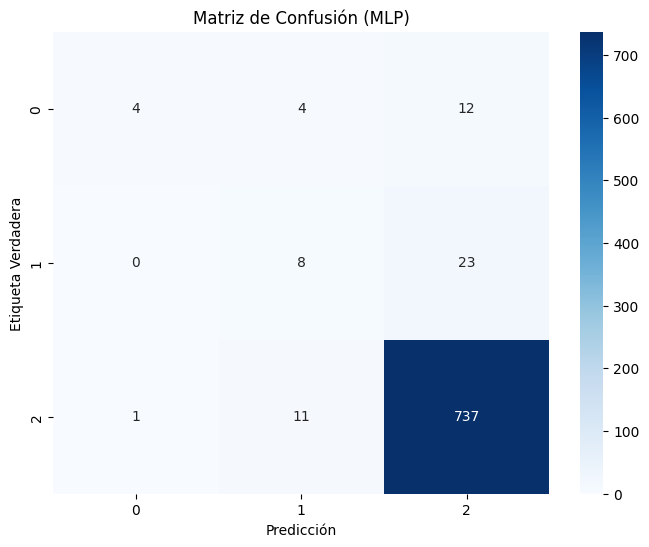

In [ ]:
# Calcular métricas
accuracy_lstm = accuracy_score(val_labels, predicted_classes_lstm)
precision_lstm = precision_score(val_labels, predicted_classes_lstm, average='weighted')
recall_lstm = recall_score(val_labels, predicted_classes_lstm, average='weighted')
f1_lstm = f1_score(val_labels, predicted_classes_lstm, average='weighted')
conf_matrix_lstm = confusion_matrix(val_labels, predicted_classes_lstm)

# Mostrar las métricas
print("Accuracy (LSTM):", accuracy_lstm)
print("Precision (LSTM):", precision_lstm)
print("Recall (LSTM):", recall_lstm)
print("F1 Score (LSTM):", f1_lstm)
print("Confusion Matrix (LSTM):\n", conf_matrix_lstm)

# Calcular la matriz de confusión
conf_matrix_mlp = confusion_matrix(val_labels, predicted_classes)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Matriz de Confusión (MLP)')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# MULTILAYER PERCEPTRONS (MLP'S)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Dropout

# Definir constantes
NB_WORDS = 10000  # Número máximo de palabras a considerar
EMBEDDING_DIM = 100  # Dimensión de los vectores de embedding
MAX_LEN = 100  # Longitud máxima de las secuencias de palabras
VAL_SIZE = 0.2  # Proporción del conjunto de datos para usar como conjunto de validación
NB_START_EPOCHS = 10  # Número de épocas para entrenar
BATCH_SIZE = 32  # Tamaño del lote durante el entrenamiento

# Cargar el conjunto de datos
df = pd.read_csv('./data/train_data.csv')
df = df.reindex(np.random.permutation(df.index))

# Renombrar la columna de texto de las revisiones
df = df.rename(columns={'reviews.text': 'reviews'})

# Seleccionar columnas relevantes
df = df[['reviews', 'sentiment']]

# Eliminar filas con valores nulos en la columna 'sentiment'
df = df.dropna(subset=['sentiment'])

# Codificar las etiquetas de sentimiento
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

# Dividir el conjunto de datos en conjuntos de entrenamiento y validación
train_texts, val_texts, train_labels, val_labels = train_test_split(df['reviews'], df['sentiment'], test_size=VAL_SIZE, random_state=42)

# Tokenizar texto y convertirlo a secuencias numéricas
tokenizer = Tokenizer(num_words=NB_WORDS)
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)

# Padding para que todas las secuencias tengan la misma longitud
train_data = pad_sequences(train_sequences, maxlen=MAX_LEN)
val_data = pad_sequences(val_sequences, maxlen=MAX_LEN)

# One Hot Encoding para las etiquetas
train_labels_oh = to_categorical(train_labels, num_classes=3)
val_labels_oh = to_categorical(val_labels, num_classes=3)

# Construir el modelo MLP
model = Sequential([
    Embedding(NB_WORDS, EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')  # 3 clases de sentimiento
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(train_data, train_labels_oh, epochs=NB_START_EPOCHS, batch_size=BATCH_SIZE, validation_data=(val_data, val_labels_oh))

# Predecir clases para los datos de validación
val_predictions = model.predict(val_data)

# Obtener las clases predichas
predicted_classes = np.argmax(val_predictions, axis=1)


Epoch 1/10
100/100 [==============================] - 7s 49ms/step - loss: 0.3506 - accuracy: 0.9212 - val_loss: 0.2427 - val_accuracy: 0.9450
Epoch 2/10
100/100 [==============================] - 4s 43ms/step - loss: 0.2606 - accuracy: 0.9356 - val_loss: 0.2037 - val_accuracy: 0.9463
Epoch 3/10
100/100 [==============================] - 4s 38ms/step - loss: 0.1262 - accuracy: 0.9494 - val_loss: 0.2293 - val_accuracy: 0.9513
Epoch 4/10
100/100 [==============================] - 4s 41ms/step - loss: 0.0577 - accuracy: 0.9766 - val_loss: 0.3369 - val_accuracy: 0.9550
Epoch 5/10
100/100 [==============================] - 4s 39ms/step - loss: 0.0318 - accuracy: 0.9869 - val_loss: 0.3461 - val_accuracy: 0.9525
Epoch 6/10
100/100 [==============================] - 4s 40ms/step - loss: 0.0143 - accuracy: 0.9966 - val_loss: 0.4404 - val_accuracy: 0.9538
Epoch 7/10
100/100 [==============================] - 3s 34ms/step - loss: 0.0078 - accuracy: 0.9987 - val_loss: 0.4206 - val_accuracy: 0.9538

Accuracy (MLP): 0.95375
Precision (MLP): 0.9464131812420785
Recall (MLP): 0.95375
F1 Score (MLP): 0.9401280356802916
Confusion Matrix (MLP):
 [[  5   0  11]
 [  0   4  24]
 [  0   2 754]]


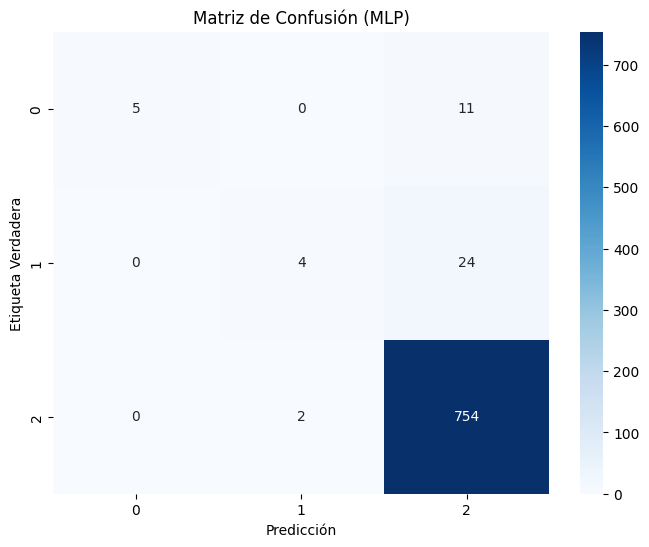

In [ ]:

# Calcular métricas
accuracy_mlp = accuracy_score(val_labels, predicted_classes)
precision_mlp = precision_score(val_labels, predicted_classes, average='weighted')
recall_mlp = recall_score(val_labels, predicted_classes, average='weighted')
f1_mlp = f1_score(val_labels, predicted_classes, average='weighted')
conf_matrix_mlp = confusion_matrix(val_labels, predicted_classes)

# Mostrar las métricas
print("Accuracy (MLP):", accuracy_mlp)
print("Precision (MLP):", precision_mlp)
print("Recall (MLP):", recall_mlp)
print("F1 Score (MLP):", f1_mlp)
print("Confusion Matrix (MLP):\n", conf_matrix_mlp)


# Calcular la matriz de confusión
conf_matrix_mlp = confusion_matrix(val_labels, predicted_classes)

# Crear el heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mlp, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title('Matriz de Confusión (MLP)')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()